In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize,stats
import seaborn as sns
from bokeh.models import CrosshairTool
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_file, show
from matplotlib.ticker import MultipleLocator
url='https://raw.githubusercontent.com/rossetl/Earthquake-Data-Analysis/main/SouthCalifornia-1982-2011_Physics-of-Data.dat'
labels=['#', 'pointer','t', 'mag', 'x', 'y', 'z'] #lat-> x long ->y dep-> z
df=pd.read_csv(url,sep="\s",names=labels,engine='python') 
df=df.drop(columns=['#'])
df=df.sort_values(by='t')
c=60*60*24

#------------Back Tree Algorithm---------------
def bta(mth):
    mask=(df['mag']>=mth) & (df['pointer']!=-1)
    i1 = df['pointer'][mask].to_numpy()
    origin=0
    originv=0
    for i in range(len(i1)):
        mask1=[]
        mask1=[i1[i]]
        while mask1[-1]!=-1:
            i2=df['pointer'][mask1[-1]] 
            mask1.append(i2)
        origin=np.insert(origin,-1,mask1[-2])
        originv=np.insert(originv,-1,mask1[:-1])
    origin=np.delete(origin,-1)#indici di riferimento dell'evento generatore
    originv=np.unique(np.delete(originv,-1))#tutti gli indici (no doppioni) che portano a ritroso all'evento generatore
    return origin, originv

def q(x,a,b,c):
    q=a+b*x+c*x**2
    return q
def f(x,a,b):
    f=a+b*x
    return f

# Origin-Main

We want study first, the relation between the origin (pointer=-1) and then the space-time relation between the origin eartquake and the main origin, where the label "main" is given above some fixed threshold.

---Fit Parameters with Errors---
a=2.19 +-0.03
b=-1.03 +-0.01
r=-0.9987


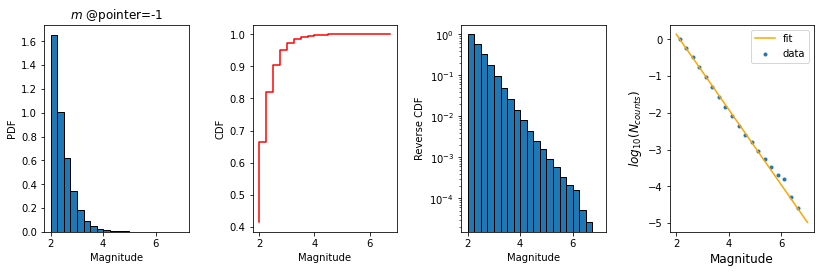

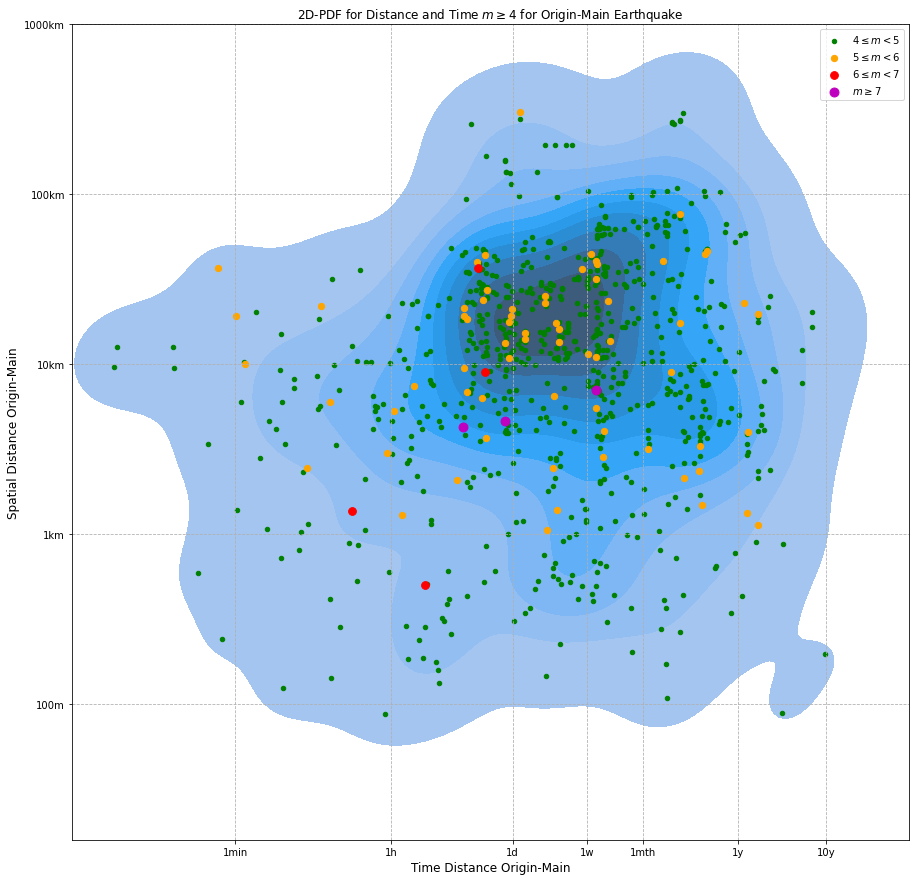

In [14]:
#------------MAIN-ORIGIN Magnitude-Study---------------
fig0, ax0 = plt.subplots(1,4,figsize=(12,4))
fig0.tight_layout(pad=3.0)

counts00, bins00, bars = ax0[0].hist(df['mag'][df['pointer']==-1], bins=np.linspace(2,7,25-4),
                                     edgecolor='black',density=1)
ax0[0].set_xlabel('Magnitude')
ax0[0].set_ylabel('PDF')
ax0[0].set_title('$m$ @pointer=-1')
ax0[1].step(bins[:-1],counts00.cumsum()/np.sum(counts00),color='red')
ax0[1].set_xlabel('Magnitude')
ax0[1].set_ylabel('CDF');

counts01, bins01, bars = ax0[2].hist(df['mag'][df['pointer']==-1], bins=np.linspace(2,7,25-4),
                                     edgecolor='black',density='cumulative',cumulative=-1)
ax0[2].set_yscale('log')
ax0[2].set_xlabel('Magnitude')
ax0[2].set_ylabel('Reverse CDF')

logmB=np.log10(counts01[:-1])
xB=(bins01[:-2]+bins01[1:-1])/2
B=optimize.curve_fit(f,xB,logmB,sigma=counts01[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
resB = stats.linregress(xB, logmB)

xx=np.linspace(2,7,100)
ax0[3].plot(xx,f(xx,B[0][0],B[0][1]),'orange',label='fit')
ax0[3].scatter(xB,logmB,label='data',linewidths=1,marker='.')
ax0[3].set_xlabel('Magnitude',size=12)
ax0[3].set_ylabel('$log_{10}(N_{counts})$',size=12)
ax0[3].legend();

print('---Fit Parameters with Errors---')
print('a=%.2f'%B[0][0],'+-%.2f'%B[1][0,0]**0.5)
print('b=%.2f'%B[0][1],'+-%.2f'%B[1][1,1]**0.5)
print('r=%.4f'%resB.rvalue)

mth=4  #---CHOOSE MTH HERE-----

origin,originv=bta(mth)#we call the back tree-alg
mask=(df['mag']>=mth) & (df['pointer']!=-1)  
i1 = df['pointer'][mask].to_numpy()
dtmc=df['t'][mask].to_numpy()-df['t'][origin].to_numpy()
x1=(df['x'][mask].to_numpy()-df['x'][origin].to_numpy())**2
y1=(df['y'][mask].to_numpy()-df['y'][origin].to_numpy())**2
z1=(df['z'][mask].to_numpy()-df['z'][origin].to_numpy())**2
drmc=(x1+y1+z1)**0.5
dfr=pd.DataFrame({'dtmc': dtmc/c, 'drmc': drmc/1000,'mag':df['mag'][mask]})


#------------Time & Distance PDF ---------------
fig1, ax1 = plt.subplots(figsize=(15,15))
lev=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

sns.kdeplot(x=np.log10(dfr['dtmc']), y=np.log10(dfr['drmc']),fill='true',ax=ax1,levels=lev)
ax1.set_xlabel('Time Distance Origin-Main',size=12)
ax1.set_ylabel('Spatial Distance Origin-Main',size=12)
ax1.set_title('2D-PDF for Distance and Time $m\geq%.0f$ for Origin-Main Earthquake'%mth)
ax1.set_xticks([-3.15,-1.38,0,0.85,1.48,2.56,3.56]) #-3.15 -> 1min  -- -4.93 -> 1sec
ax1.set_xticklabels(['1min','1h','1d','1w','1mth','1y','10y']);
ax1.set_yticks([-1,0,1,2,3,4])
ax1.set_yticklabels(['100m','1km','10km','100km','1000km','10000km'])
ax1.set_xlim(-5,4.5)
ax1.set_ylim(-1.8,3)
ax1.grid(which='both',b=1, linestyle='dashed')

mask1=(df['mag']<(mth+1)) & (df['mag']>=mth) 
ax1.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),
           color='green',label=r'$%s\leq m<%s$'%(mth,mth+1),s=20)
mask1=(df['mag']<(mth+2)) & (df['mag']>=(mth+1)) 
ax1.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),
           color='orange',label=r'$%s\leq m<%s$'%(mth+1,mth+2),s=40)
mask1=(df['mag']<(mth+3)) & (df['mag']>=(mth+2)) 
ax1.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),
           color='red',label=r'$%s\leq m<%s$'%(mth+2,mth+3),s=60)
mask1=dfr['mag']>=(mth+3)
ax1.scatter(np.log10(dfr['dtmc'][mask1]),np.log10(dfr['drmc'][mask1]),
           color='m',label='$m\geq%s$'%(mth+3),s=80)
ax1.legend();

# Foreshock

We want study the relation between the magnitude and those earthquake that come between the origin and the main.

---Fit Parameters with Errors 3P---
a=-0.25 +-0.05
b=0.32 +-0.03
c=-0.10 +-0.00
---Fit Parameters with Errors 2P---
a=0.86 +-0.08
b=-0.36 +-0.03
r=-0.9657


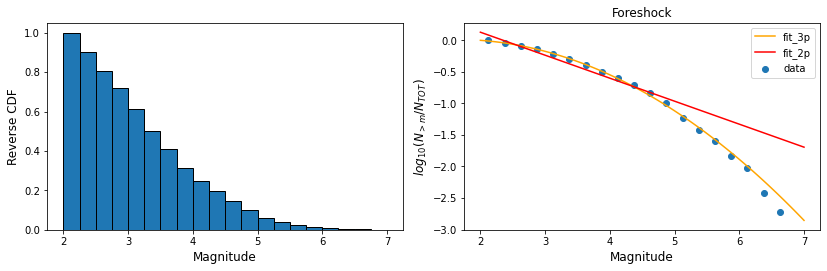

In [15]:
fig2, ax2 = plt.subplots(1,2,figsize=(12,4))
fig2.tight_layout(pad=3.0)

mth=4    #---CHOOSE MTH HERE-----

origin,originv=bta(mth)  #we call the back tree-alg
db=pd.DataFrame({'mag': df['mag'][originv]}) #in origin stiamo consierando terremoti importanti con m>mth
mthu=2 #lower magnitude, we can adjust it (it's difficult to detect small eartquake)
db=db['mag'][db['mag']>mthu]
counts2, bins2, bars = ax2[0].hist(db, bins=np.linspace(mthu,7,25-4),edgecolor='black',density=1,cumulative=-1)
ax2[0].set_xlabel('Magnitude',size=12)
ax2[0].set_ylabel('Reverse CDF',size=12)

yhb=counts2[counts2>0]
logmF=np.log10(yhb)
xF=(bins2[:-1]+bins2[1:len(counts2)+1])/2
xF=xF[counts2>0]

F=optimize.curve_fit(q,xF,logmF,sigma=counts2[counts2>0]**(-0.5),p0=[0.1,0.2,0])  #poisson error is assumed
Q=optimize.curve_fit(f,xF,logmF,sigma=counts2[counts2>0]**(-0.5),p0=[6,-1])  #poisson error is assumed
resF = stats.linregress(xF, logmF)

xx=np.linspace(2,7,100)
ax2[1].plot(xx,q(xx,F[0][0],F[0][1],F[0][2]),'orange',label='fit_3p')
ax2[1].plot(xx,f(xx,Q[0][0],Q[0][1]),'red',label='fit_2p')
ax2[1].scatter(xF,logmF,label='data',linewidths=1)
ax2[1].set_xlabel('Magnitude',size=12)
ax2[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
ax2[1].set_title('Foreshock')
ax2[1].legend();

print('---Fit Parameters with Errors 3P---')
print('a=%.2f'%F[0][0],'+-%.2f'%F[1][0,0]**0.5)
print('b=%.2f'%F[0][1],'+-%.2f'%F[1][1,1]**0.5)
print('c=%.2f'%F[0][2],'+-%.2f'%F[1][2,2]**0.5)
print('---Fit Parameters with Errors 2P---')
print('a=%.2f'%Q[0][0],'+-%.2f'%Q[1][0,0]**0.5)
print('b=%.2f'%Q[0][1],'+-%.2f'%Q[1][1,1]**0.5)
print('r=%.4f'%resF.rvalue)

# Aftershock

We want study the relation between the magnitude and those earthquake that are generated by the main (only the first generation).

---Fit Parameters with Errors---
a=1.86 +-0.02
b=-0.87 +-0.01
r=-0.9980


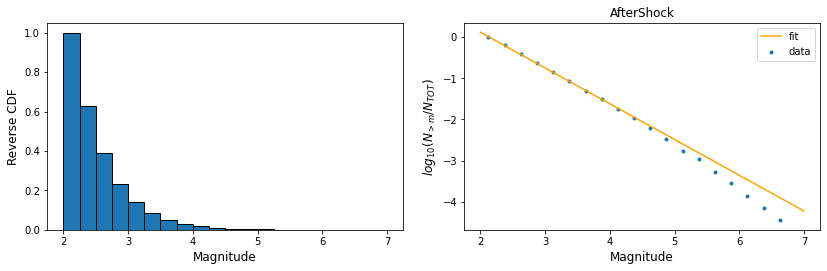

In [16]:
mth=4   #---CHOOSE MTH HERE-----

drf=df['mag'][df['mag']>=mth] 
i1=drf.index
n=0
for i in range(len(i1)):
    ind=(df['pointer'][df['pointer']==i1[i]].index).to_numpy() 
    n=np.insert(n,-1,ind)
n=np.delete(n,-1) #cerco tutti i terremoti che puntano ai terremoti scelti.

fig4, ax4 = plt.subplots(1,2,figsize=(12,4))
fig4.tight_layout(pad=3.0)

counts4, bins4, bars = ax4[0].hist(df['mag'][n], bins=np.linspace(2,7,25-4),edgecolor='black',density=1,cumulative=-1)
ax4[0].set_xlabel('Magnitude',size=12)
ax4[0].set_ylabel('Reverse CDF',size=12)

logmA=np.log10(counts4[:-1])
xA=(bins4[:-2]+bins4[1:-1])/2
A=optimize.curve_fit(f,xA,logmA,sigma=counts4[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
resA = stats.linregress(xA, logmA)

xx=np.linspace(2,7,100)
ax4[1].set_xlabel('Magnitude',size=12)
ax4[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
ax4[1].plot(xx,f(xx,A[0][0],A[0][1]),'orange',label='fit')
ax4[1].scatter(xA,logmA,label='data',linewidths=1,marker='.')
ax4[1].set_title('AfterShock')
ax4[1].legend();

print('---Fit Parameters with Errors---')
print('a=%.2f'%A[0][0],'+-%.2f'%A[1][0,0]**0.5)
print('b=%.2f'%A[0][1],'+-%.2f'%A[1][1,1]**0.5)
print('r=%.4f'%resA.rvalue)

# Gutenberg–Richter Law 

We want study the magnitude respect all the possible earthquake 

---Fit Parameters with Errors---
a=2.09 +-0.02
b=-0.98 +-0.01
r=-0.9994


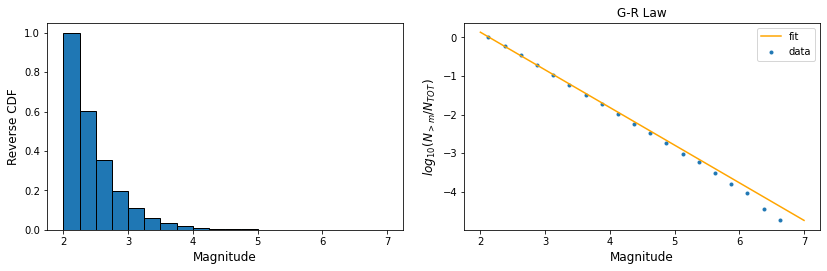

In [17]:
fig5, ax5 = plt.subplots(1,2,figsize=(12,4))
fig5.tight_layout(pad=3.0)

counts5, bins5, bars = ax5[0].hist(df['mag'], bins=np.linspace(2,7,25-4),edgecolor='black',density=1,cumulative=-1)
ax5[0].set_xlabel('Magnitude',size=12)
ax5[0].set_ylabel('Reverse CDF',size=12)

logmG=np.log10(counts5[:-1])  
xG=(bins5[:-2]+bins5[1:-1])/2
G=optimize.curve_fit(f,xG,logmG,sigma=counts5[:-1]**(-0.5),p0=[6,-1])  #poisson error is assumed
resG = stats.linregress(xG,logmG)

xx=np.linspace(2,7,100)
ax5[1].set_xlabel('Magnitude',size=12)
ax5[1].set_ylabel('$log_{10}(N_{>m} /N_{TOT})$',size=12)
ax5[1].plot(xx,f(xx,G[0][0],G[0][1]),'orange',label='fit')
ax5[1].scatter(xG,logmG,label='data',linewidths=1,marker='.')
ax5[1].set_title('G-R Law')
ax5[1].legend();
print('---Fit Parameters with Errors GR---')
print('a=%.2f'%G[0][0],'+-%.2f'%G[1][0,0]**0.5)
print('b=%.2f'%G[0][1],'+-%.2f'%G[1][1,1]**0.5)
print('r=%.4f'%resG.rvalue)

# Universal Law (Part 1)

In [23]:
#dataframe

a = figure(title='PDF & Fit Magnitude',title_location = "above",plot_width=800, plot_height=600)
a.xaxis.axis_label = 'r (km)'
a.yaxis.axis_label = 'Pm(r)'

#scatter
a.scatter(xA, logmA, color="blue",   legend_label="Aftershock",  marker = 'circle',   size=7)
a.scatter(xB, logmB, color="orange", legend_label="Originshock", marker = 'square',   size=7)
a.scatter(xF, logmF, color="green",  legend_label="Foreshock",   marker = 'triangle', size=7)
a.scatter(xG, logmG, color="red",    legend_label="GR-Law",      marker ='diamond',  size=7)

#fit
a.line(xx, f(xx,A[0][0],A[0][1]), line_width=2, legend_label="fit A",  color="blue")
a.line(xx, f(xx,B[0][0],B[0][1]), line_width=2, legend_label="fit O",  color="orange")
a.line(xx, q(xx,F[0][0],F[0][1],F[0][2]), line_width=2, legend_label="fit F",  color="green")
a.line(xx, f(xx,G[0][0],G[0][1]), line_width=2, legend_label="fit GR", color="red")

a.legend.location = "top_right"
a.legend.click_policy="hide"
show(a)

Questa potrebbe essere una proposta di Legge Universale: i punti rossi sono riferiti alla magnitudo dei terremoti che sono etichettati con -1, ovvero sia che non sono originati da un precedente evento; i punti blu sono riferiti alla magnitudo dei terremoti (sciame) che sono avvenuti dopo la verifica di un terremoto importante (m>5); i punti in verde sono riferiti alla magnitudo di quei terremoti che intercedono tra un terremoto importante (m>5) e il suo evento originatore. In magenta la legge di GR (slope -0.98 simile a -0.95 riportato nel paper.)
1. AfterShock: considero solo gli eventi immediatamente collegati al Main
2. ForeShock: considero solo eventi prima del Main
3. Origin-Main: considero solo eventi originatori e i Main
4. GR: considero tutti i terremoti

# Universal Law (Part 2)

# $P_{m,R}(t)$ 

---Fit Parameters with Errors---
a=-2.02 +-0.07
b=-0.84 +-0.02
r=-0.9393


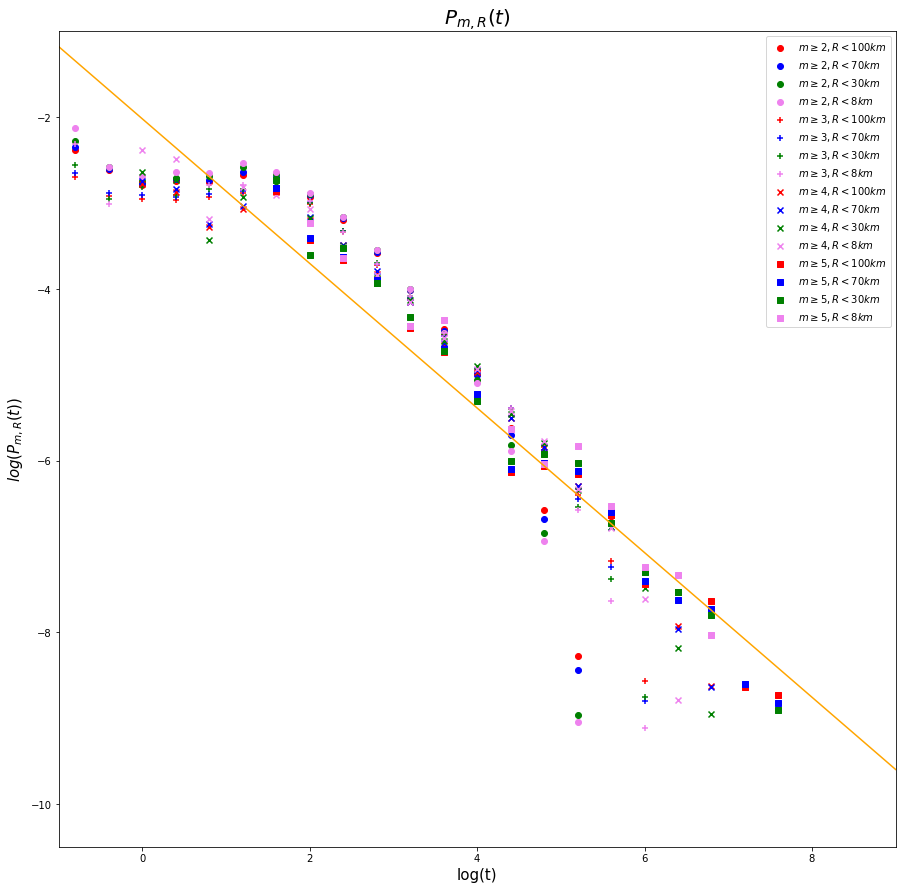

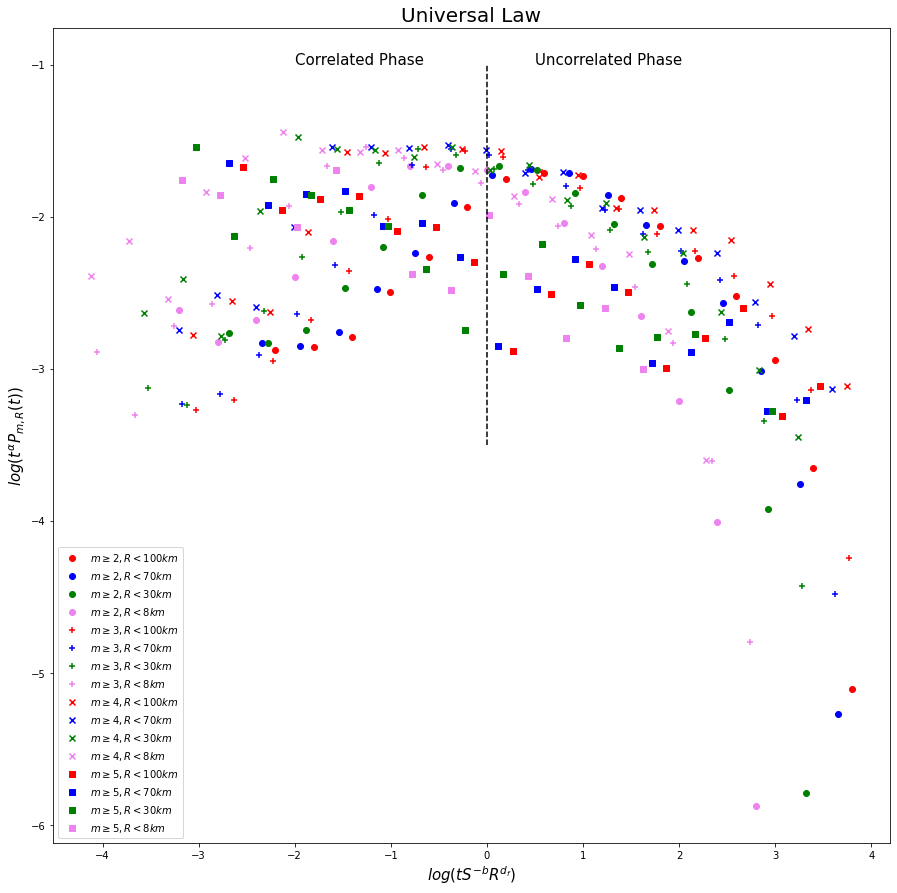

In [10]:
magth=np.arange(2,6,1)
Rth=np.array([100000,70000,30000,8000])
R=np.matrix([Rth[0]*np.ones(4),Rth[1]*np.ones(4),Rth[2]*np.ones(4),Rth[3]*np.ones(4)])
l=np.shape(R)[0]

colors=['red','blue','green','violet'] # threshold R selected
markers=['o','+','x','s'] #corresponds to the number of magnitude selected (2,3,4,5)

def p(i,j):
    if i==1 and j==0:
     p=2
    elif i==1 and j==1:
     p=3
    else:
     p=i+j
    return p

Yu=[]
Xu=[]

#m=2,3,4,5
dfv=np.array([0.91,0.94,0.97,0.95]) #old (30)
alpha=np.array([0.61,0.72,0.81,0.74]) #best (different values of bins size)
b=G[0][1]
const=-4

fig6, ax6 = plt.subplots(figsize=(15,15))
fig7, ax7 = plt.subplots(figsize=(15,15))
 
for i in range(2):
    for j in range(2):
        for z in range(l):
            mask=(df['mag']>=magth[p(i,j)])
            dr=df[mask]
            dr=dr.drop(columns=['t','pointer','mag'])
            dr['dpw']=((dr.diff()**2).sum(axis=1))**0.5 #dpw stay  for distance pairs waise
            dr.insert(loc=0, column='t', value=df['t'][dr.index])
            dr.insert(loc=1, column='dt', value=df['t'][dr.index])
            dr['dt']=dr['dt'].diff()
            dr=dr.drop(dr.index[0])
            Tlim=0.0001 #40s as written in the paper
            Tlimm=10**20
            mask1=(dr['dt']<Tlim) | (dr['dt']>Tlimm)
            dr=dr.drop(dr[mask1].index)
            dr=dr.drop(dr[dr['dpw'] > R[z,p(i,j)]].index)

            counts6, bins6, bars =ax6.hist(dr['dt'], visible=0,bins=np.logspace(-1,9,26),density=1) #-1,8 19  // -1,9 26
            yhb=counts6[counts6>0]
            yhb=yhb
            Yu=np.insert(Yu,0,yhb)
            xF=(bins6[:-1]*bins6[1:len(counts6)+1])**0.5
            xF=xF[counts6>0]
            Xu=np.insert(Xu,0,xF)
            
            ax6.scatter(np.log10(xF),np.log10(yhb),color=colors[z],marker=markers[p(i,j)],
                        label='$m\geq%s, R<%.0f km$'%(magth[p(i,j)],R[z,p(i,j)]/1000))

            
            Yt1=alpha[p(i,j)]*np.log10(xF)+np.log10(yhb)
            Xt1=np.log10(xF) + b*magth[p(i,j)] + dfv[p(i,j)]*np.log10(R[z,p(i,j)]) +const
            
            ax7.scatter(Xt1,Yt1,color=colors[z],marker=markers[p(i,j)],
                        label='$m\geq%s, R<%.0f km$'%(magth[p(i,j)],R[z,p(i,j)]/1000))

ax7.set_title('Universal Law',size=20)
ax7.set_xlabel('$log(tS^{-b}R^{d_{f}})$',size=15)
ax7.set_ylabel('$log(t^{\\alpha}P_{m,R}(t))$',size=15)
ax7.plot(np.zeros(100),np.linspace(-3.5,-1,100),'k--')
ax7.text(0.5,-1, 'Uncorrelated Phase',size=15)
ax7.text(-2,-1, 'Correlated Phase',size=15)
#ax7.text(-2,-4, '$\\alpha=[%s, %s, %s, %s]$'%(alpha[0],alpha[1],alpha[2],alpha[3]),size=15)
#ax7.text(-2,-4.2, '$d_{f}=[%s, %s, %s, %s]$'%(dfv[0],dfv[1],dfv[2],dfv[3]),size=15)
#ax7.text(-2,-4.4, 'b=%.2f'%b,size=15)
ax7.legend(loc='best')

U=optimize.curve_fit(f,np.log10(Xu),np.log10(Yu),p0=[1,-1]) #no errors here***
resU = stats.linregress(np.log10(Xu),np.log10(Yu))
xx=np.linspace(-1,9,100)

ax6.plot(xx,f(xx,U[0][0],U[0][1]),'orange')
ax6.set_xlim(-1,9);
ax6.set_ylim(-10.5,-1)
ax6.set_title('$P_{m,R}(t)$',size=20)
ax6.set_xlabel('log(t)',size=15)
ax6.set_ylabel('$log(P_{m,R}(t))$',size=15)
ax6.legend(loc='upper right');

print('---Fit Parameters with Errors---')
print('a=%.2f'%U[0][0],'+-%.2f'%U[1][0,0]**0.5)
print('b=%.2f'%U[0][1],'+-%.2f'%U[1][1,1]**0.5)
print('r=%.4f'%resU.rvalue)